**This notebook will be dedicated to the training and optimization activities of an XGBoost regression model**

In [2]:
from src import data_utils, preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

Only run the cell below by removing the # symbol if you haven't downloaded the zones data

In [3]:
# run this cell to download the required data files containing the trip and zones information

# data_utils.download_zones_data('https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip')

In [4]:
# this list contains the file names from where we wish to take all the data from
files = ['yellow_tripdata_2022-01.parquet',
         'yellow_tripdata_2022-02.parquet',
         'yellow_tripdata_2022-03.parquet',
         'yellow_tripdata_2022-04.parquet',
         'yellow_tripdata_2022-05.parquet',
         'yellow_tripdata_2022-06.parquet',
         'yellow_tripdata_2022-07.parquet',
         'yellow_tripdata_2022-08.parquet',
         'yellow_tripdata_2022-09.parquet',
         'yellow_tripdata_2022-10.parquet',
         'yellow_tripdata_2022-11.parquet',
         'yellow_tripdata_2022-12.parquet']

In [5]:
# first we get our cleaned data set
df_og = data_utils.sampled_yearly_data(files,250000)
# now we get our X, and y
X, y_travel_time, y_fare_amount = data_utils.get_feature_target(df_og)

In [6]:
y_fare_amount.max()

60.0

In [7]:
column_names_order = ['passenger_count','trip_distance','day','month','is_weekend','afternoon','morning','night']

In [8]:
# and we then get our training and testing sets
# we are going to get two sets of y labels, one for travel_time and another for fare_amount
X_train, X_test, y_train_travel_time, y_test_travel_time, y_train_fare_amount, y_test_fare_amount = data_utils.get_train_test_sets(X, y_travel_time, y_fare_amount)

In [9]:
# we can further split the training set into training and validation
X_train, X_val, y_train_travel_time, y_val_travel_time, y_train_fare_amount, y_val_fare_amount = data_utils.get_train_test_sets(X_train, y_train_travel_time, y_train_fare_amount)

In [10]:
# now using the training, validation, and testing sets we can preprocess our data
X_train, X_val, X_test = preprocessing.preprocess_data(X_train, X_val, X_test)

Input train data shape:  (1920000, 6)
Input val data shape:  (480000, 6)
Input test data shape:  (600000, 6) 

Output train data shape:  (1920000, 8)
Output val data shape:  (480000, 8)
Output test data shape:  (600000, 8)


In [11]:
print(f'Passenger count: {X_train[0,0]}\n Trip distance: {X_train[0,1]}\n Day: {X_train[0,2]}\n Month: {X_train[0,3]}\n is_weekend: {X_train[0,4]}\n afternoon: {X_train[0,5]}\n morning: {X_train[0,6]}\n night: {X_train[0,7]}')

Passenger count: 0.14285714285714285
 Trip distance: 0.008847575316384816
 Day: 0.41379310344827586
 Month: 0.09090909090909091
 is_weekend: 1.0
 afternoon: 0.0
 morning: 0.0
 night: 1.0


**Initial results with no finetuning**

In [12]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [13]:
# initial run with no finetuning for fare amount
# fa = fare amount
xg_fa = XGBRegressor(seed=42)
xg_fa.fit(X_train,y_train_fare_amount)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [14]:
preds_fa = xg_fa.predict(X_val)

In [15]:
# measure our results
r2_fare = r2_score(y_val_fare_amount, preds_fa)
mae = mean_absolute_error(y_val_fare_amount, preds_fa)
# agregar r2
print(f'R2 score: {r2_fare}')
print(f'Mean Absolute Error: {mae}')

R2 score: 0.9526765686146156
Mean Absolute Error: 1.4084448405232153


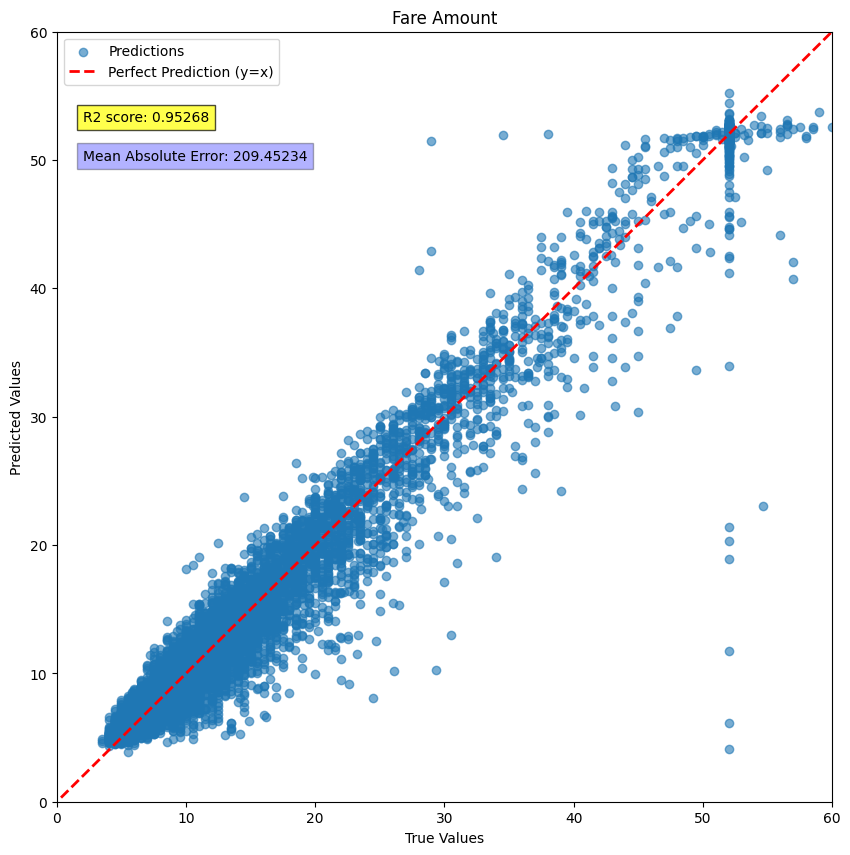

In [23]:
# plot the differences
plt.figure(figsize=(10,10))
plt.scatter(y_val_fare_amount[:10000], preds_fa[:10000], alpha=0.6, label='Predictions')
# axis limits
plt.xlim([0,60])
plt.ylim([0,60])
#plotting perfect line
min_val = min(np.min(y_val_fare_amount), np.min(preds_fa))
max_val = max(np.max(y_val_fare_amount), np.max(preds_fa))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction (y=x)')
# other settings
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Fare Amount")
#plt.grid(True)
plt.legend()
plt.text(2,53,f'R2 score: {r2_fare:.5f}',bbox=dict(facecolor='yellow', alpha=0.7))
plt.text(2,50,f'Mean Absolute Error: {mae:.5f}',bbox=dict(facecolor='blue', alpha=0.3))
plt.show()

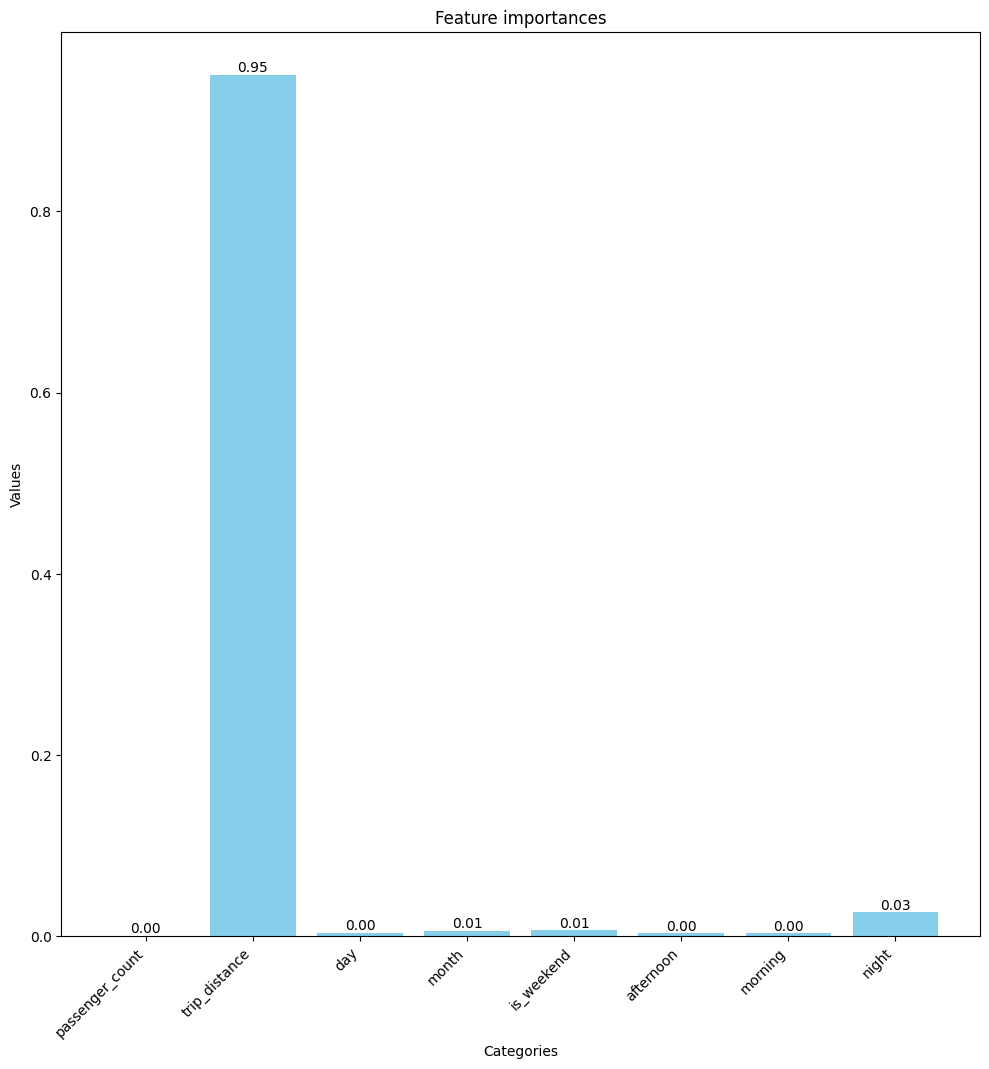

In [17]:
# Feature importances when predicting the fare amount
# bar chart
plt.figure(figsize=(10,10))
fare_bars = plt.bar(column_names_order,xg_fa.feature_importances_,color='skyblue')
plt.xlabel("Categories")
plt.ylabel("Values")
plt.title("Feature importances")
# so everything fits and is readable
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
# to add values on top of each bar
for bar in fare_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, # x position (center of bar)
                yval,                             # y position (top of bar)
                f'{yval:.2f}',                    # Text label (format value)
                va='bottom',                      # Vertical alignment (above bar)
                ha='center') 


plt.show()

Move trained model to pkl file to be used later on by the API

**This was the code used to save the model to our model/models folder**

save_folder = str(os.getcwd() + "/model/models")
filename = "model_fa.pkl"
save_path = os.path.join(save_folder, filename)

os.makedirs(save_folder, exist_ok=True)

with open(save_path,'wb') as f:
    pickle.dump(xg_fa,f)

In [18]:
# initial run with no finetuning for travel time
# tt = travel time
xg_tt = XGBRegressor(seed=42)
xg_tt.fit(X_train,y_train_travel_time)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [19]:
preds_tt = xg_tt.predict(X_val)

In [20]:
# measure our results
r2_travel = r2_score(y_val_travel_time, preds_tt)
mae = mean_absolute_error(y_val_travel_time, preds_tt)
# agregar r2
print(f'R2 score: {r2_travel}')
print(f'Mean Absolute Error: {mae}')

R2 score: 0.7726498030236914
Mean Absolute Error: 209.45234418856302


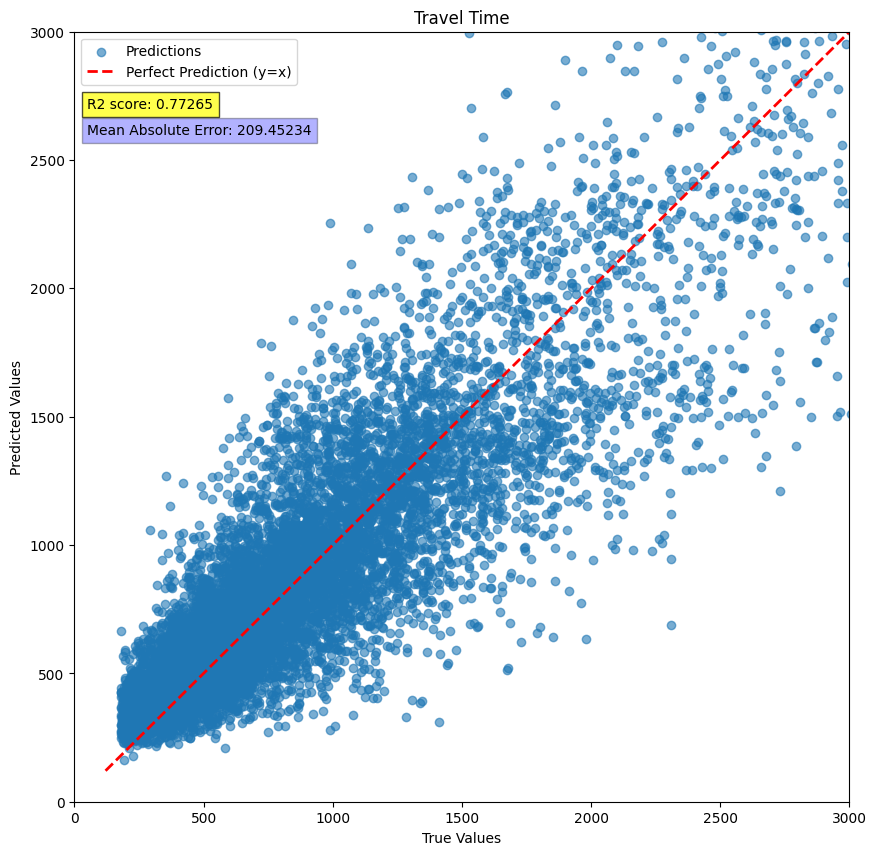

In [24]:
# plot the differences
plt.figure(figsize=(10,10))
plt.scatter(y_val_travel_time[:10000], preds_tt[:10000], alpha=0.6, label='Predictions')
# axis limits
plt.xlim([0,3000])
plt.ylim([0,3000])
#plotting perfect line
min_val = min(np.min(y_val_travel_time), np.min(preds_tt))
max_val = max(np.max(y_val_travel_time), np.max(preds_tt))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction (y=x)')
# other settings
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Travel Time")
#plt.grid(True)
plt.legend()
plt.text(50,2700,f'R2 score: {r2_travel:.5f}',bbox=dict(facecolor='yellow', alpha=0.7))
plt.text(50,2600,f'Mean Absolute Error: {mae:.5f}',bbox=dict(facecolor='blue', alpha=0.3))
plt.show()

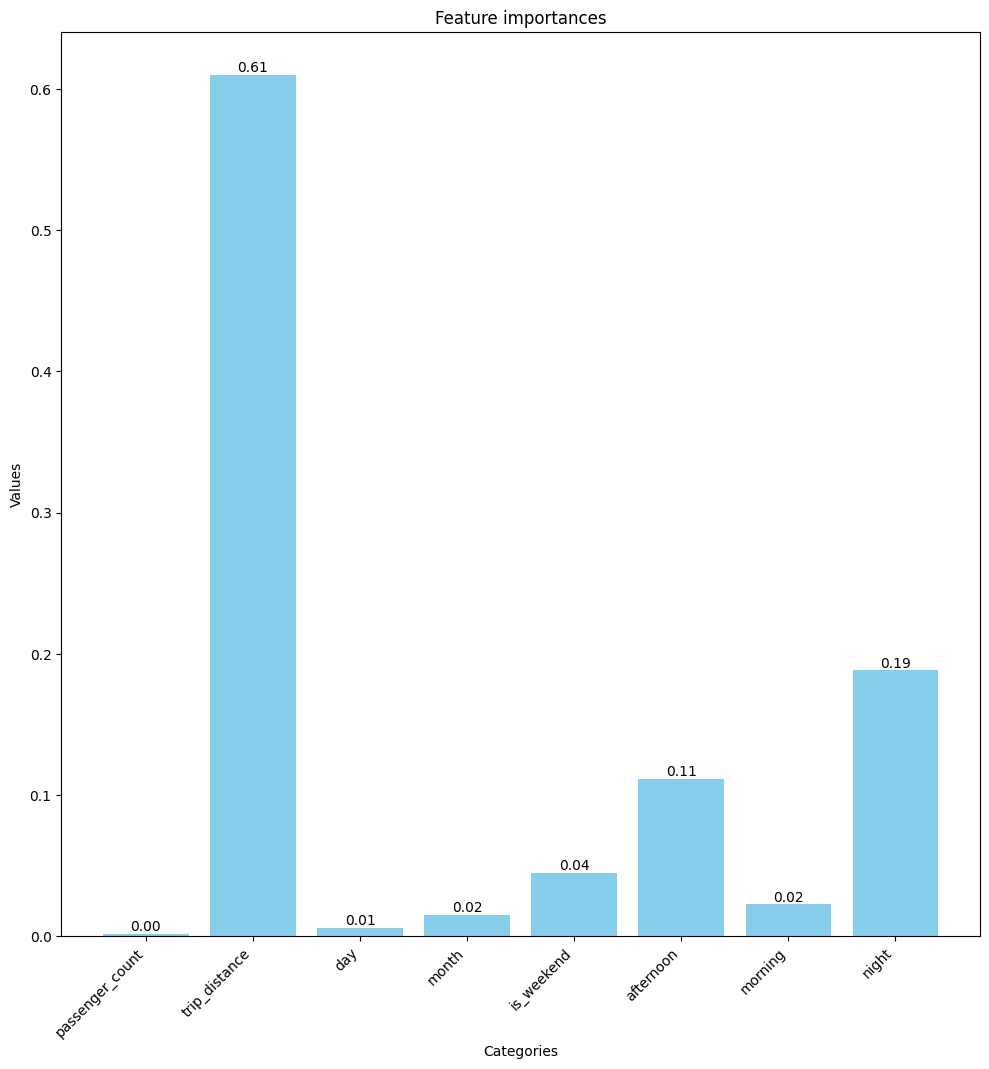

In [22]:
# bar charts for feature importances when predicting the travel time
# bar chart
plt.figure(figsize=(10,10))
fare_bars = plt.bar(column_names_order,xg_tt.feature_importances_,color='skyblue')
plt.xlabel("Categories")
plt.ylabel("Values")
plt.title("Feature importances")
# so everything fits and is readable
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
# to add values on top of each bar
for bar in fare_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, # x position (center of bar)
                yval,                             # y position (top of bar)
                f'{yval:.2f}',                    # Text label (format value)
                va='bottom',                      # Vertical alignment (above bar)
                ha='center') 


plt.show()

**This was the code used to save the model to our model/models folder**

save_folder = str(os.getcwd() + "/model/models")
filename = "model_tt.pkl"
save_path = os.path.join(save_folder, filename)

os.makedirs(save_folder, exist_ok=True)

with open(save_path,'wb') as f:
    pickle.dump(xg_tt,f)

**Hyperparameter tuning**

In [31]:
import xgboost as xgb

**Travel time**

We will only focus on doing hyperparameter tuning for the travel time predictions, since the R2 score for the baseline model was significantly lower than the one for the fare amount

In [32]:
# turn training and validation datasets to dmatrices that work with XGBoost library
dtrain_tt = xgb.DMatrix(X_train, label=y_train_travel_time)
dval_tt = xgb.DMatrix(X_val, label=y_val_travel_time)
dtest_tt = xgb.DMatrix(X_test, label=y_test_travel_time)

In [33]:
# we will choose from the following parameters to perform our cross validation search
xg_params_tt = {'max_depth':6,
             'min_child_weight':1,
             'eta':0.3,
             'subsample':1,
             'colsample_bytree':1,
             'objective':'reg:squarederror',
             'eval_metric':'mae'
             }

In [34]:
n_boosting_rounds = 1000

In [35]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(8,12)
    for min_child_weight in range(12,16)
]

In [36]:
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    xg_params_tt['max_depth'] = max_depth
    xg_params_tt['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        xg_params_tt,
        dtrain_tt,
        num_boost_round=n_boosting_rounds,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: Max depth {}, Min Child Weight {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=8, min_child_weight=12
	MAE 208.91228072918653 for 93 rounds
CV with max_depth=8, min_child_weight=13
	MAE 208.89866613010963 for 110 rounds
CV with max_depth=8, min_child_weight=14
	MAE 208.89677614676953 for 109 rounds
CV with max_depth=8, min_child_weight=15
	MAE 208.90186270725727 for 90 rounds
CV with max_depth=9, min_child_weight=12
	MAE 209.00817835760913 for 68 rounds
CV with max_depth=9, min_child_weight=13
	MAE 208.94100110733513 for 60 rounds
CV with max_depth=9, min_child_weight=14
	MAE 209.00517831981182 for 65 rounds
CV with max_depth=9, min_child_weight=15
	MAE 208.9413685383479 for 67 rounds
CV with max_depth=10, min_child_weight=12
	MAE 209.08769189391933 for 39 rounds
CV with max_depth=10, min_child_weight=13
	MAE 209.0966125994364 for 43 rounds
CV with max_depth=10, min_child_weight=14
	MAE 209.08036534356674 for 47 rounds
CV with max_depth=10, min_child_weight=15
	MAE 209.0919923329512 for 46 rounds
CV with max_depth=11, min_child_weight=12
	MAE 20

In [37]:
# we now set max depth and min child weight to the values that we previously found
xg_params_tt['max_depth'] = best_params[0]
xg_params_tt['min_child_weight'] = best_params[1]

In [40]:
# now we train subsample and colsample
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [41]:
min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    xg_params_tt['subsample'] = subsample
    xg_params_tt['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        xg_params_tt,
        dtrain_tt,
        num_boost_round=n_boosting_rounds,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: subsample {}, colsample {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=1.0, colsample=1.0
	MAE 208.89677614676953 for 109 rounds
CV with subsample=1.0, colsample=0.9
	MAE 208.89922177518605 for 96 rounds
CV with subsample=1.0, colsample=0.8
	MAE 208.96904524740376 for 98 rounds
CV with subsample=1.0, colsample=0.7
	MAE 209.28069618765912 for 97 rounds
CV with subsample=0.9, colsample=1.0
	MAE 209.07990983204445 for 94 rounds
CV with subsample=0.9, colsample=0.9
	MAE 209.05735926055507 for 98 rounds
CV with subsample=0.9, colsample=0.8
	MAE 209.1549434699297 for 100 rounds
CV with subsample=0.9, colsample=0.7
	MAE 209.4523602190574 for 97 rounds
CV with subsample=0.8, colsample=1.0
	MAE 209.20544010746477 for 88 rounds
CV with subsample=0.8, colsample=0.9
	MAE 209.19520115272206 for 121 rounds
CV with subsample=0.8, colsample=0.8
	MAE 209.23154729948442 for 98 rounds
CV with subsample=0.8, colsample=0.7
	MAE 209.5079053601702 for 97 rounds
CV with subsample=0.7, colsample=1.0
	MAE 209.3620983729482 for 97 rounds
CV with subsample=0.7, col

In [43]:
# we now set subsample and colsample to the values that we previously found
xg_params_tt['subsample'] = best_params[0]
xg_params_tt['colsample_bytree'] = best_params[1]

In [44]:
min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    xg_params_tt['eta'] = eta
    # Run and time CV
    cv_results = xgb.cv(
            xg_params_tt,
            dtrain_tt,
            num_boost_round=n_boosting_rounds,
            seed=42,
            nfold=5,
            metrics=['mae'],
            early_stopping_rounds=10
          )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best eta: {}, MAE: {}".format(best_params, min_mae))

CV with eta=0.3
	MAE 208.89677614676953 for 109 rounds

CV with eta=0.2
	MAE 208.73128557037512 for 161 rounds

CV with eta=0.1
	MAE 208.6677281905532 for 293 rounds

CV with eta=0.05
	MAE 208.66901027534806 for 610 rounds

CV with eta=0.01
	MAE 210.09169456508158 for 999 rounds

CV with eta=0.005
	MAE 212.51599298245114 for 999 rounds

Best eta: 0.1, MAE: 208.6677281905532


In [45]:
xg_params_tt['eta'] = best_params

In [46]:
# now we test our model with our best results obtained
model_tt = xgb.train(xg_params_tt,
                     dtrain_tt,
                     num_boost_round = n_boosting_rounds,
                     evals = [(dval_tt,'Test')],
                     early_stopping_rounds = 10)

[0]	Test-mae:436.53888
[1]	Test-mae:404.60203
[2]	Test-mae:376.77143
[3]	Test-mae:352.62894
[4]	Test-mae:331.77992
[5]	Test-mae:313.83755
[6]	Test-mae:298.51202
[7]	Test-mae:285.45995
[8]	Test-mae:274.36653
[9]	Test-mae:264.96783
[10]	Test-mae:257.03083
[11]	Test-mae:250.33171
[12]	Test-mae:244.65149
[13]	Test-mae:239.90965
[14]	Test-mae:235.90140
[15]	Test-mae:232.48959
[16]	Test-mae:229.63432
[17]	Test-mae:227.22062
[18]	Test-mae:225.18077
[19]	Test-mae:223.44181
[20]	Test-mae:221.98122
[21]	Test-mae:220.75017
[22]	Test-mae:219.70655
[23]	Test-mae:218.79833
[24]	Test-mae:218.02892
[25]	Test-mae:217.34876
[26]	Test-mae:216.78622
[27]	Test-mae:216.29694
[28]	Test-mae:215.87532
[29]	Test-mae:215.49944
[30]	Test-mae:215.19755
[31]	Test-mae:214.92101
[32]	Test-mae:214.65552
[33]	Test-mae:214.43590
[34]	Test-mae:214.23404
[35]	Test-mae:214.01890
[36]	Test-mae:213.85663
[37]	Test-mae:213.70295
[38]	Test-mae:213.54142
[39]	Test-mae:213.38712
[40]	Test-mae:213.27411
[41]	Test-mae:213.16512
[4

In [47]:
# now that we now the best num of iterations, then we set the number of boosting rounds to that instead
# add plus 1 because the limit is non inclusive
n_boosting_rounds = model_tt.best_iteration + 1

In [48]:
# we now train our model with all the optimized parameters
best_xgb = xgb.train(xg_params_tt,
                     dtrain_tt,
                     num_boost_round = n_boosting_rounds,
                     evals = [(dval_tt,'Test')])

[0]	Test-mae:436.53888
[1]	Test-mae:404.60203
[2]	Test-mae:376.77143
[3]	Test-mae:352.62894
[4]	Test-mae:331.77992
[5]	Test-mae:313.83755
[6]	Test-mae:298.51202
[7]	Test-mae:285.45995
[8]	Test-mae:274.36653
[9]	Test-mae:264.96783
[10]	Test-mae:257.03083
[11]	Test-mae:250.33171
[12]	Test-mae:244.65149
[13]	Test-mae:239.90965
[14]	Test-mae:235.90140
[15]	Test-mae:232.48959
[16]	Test-mae:229.63432
[17]	Test-mae:227.22062
[18]	Test-mae:225.18077
[19]	Test-mae:223.44181
[20]	Test-mae:221.98122
[21]	Test-mae:220.75017
[22]	Test-mae:219.70655
[23]	Test-mae:218.79833
[24]	Test-mae:218.02892
[25]	Test-mae:217.34876
[26]	Test-mae:216.78622
[27]	Test-mae:216.29694
[28]	Test-mae:215.87532
[29]	Test-mae:215.49944
[30]	Test-mae:215.19755
[31]	Test-mae:214.92101
[32]	Test-mae:214.65552
[33]	Test-mae:214.43590
[34]	Test-mae:214.23404
[35]	Test-mae:214.01890
[36]	Test-mae:213.85663
[37]	Test-mae:213.70295
[38]	Test-mae:213.54142
[39]	Test-mae:213.38712
[40]	Test-mae:213.27411
[41]	Test-mae:213.16512
[4

In [49]:
# now we evaluate our model against our test set
# first we make the predictions
best_preds_tt = best_xgb.predict(dtest_tt)

In [50]:
# measure our results
r2_travel = r2_score(y_test_travel_time, best_preds_tt)
mae = mean_absolute_error(y_test_travel_time, best_preds_tt)
rmse = root_mean_squared_error(y_test_travel_time, best_preds_tt)
# agregar r2
print(f'R2 score: {r2_travel}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

R2 score: 0.7732490865125199
Mean Absolute Error: 208.45121475056965
Root Mean Squared Error: 304.02030868915614


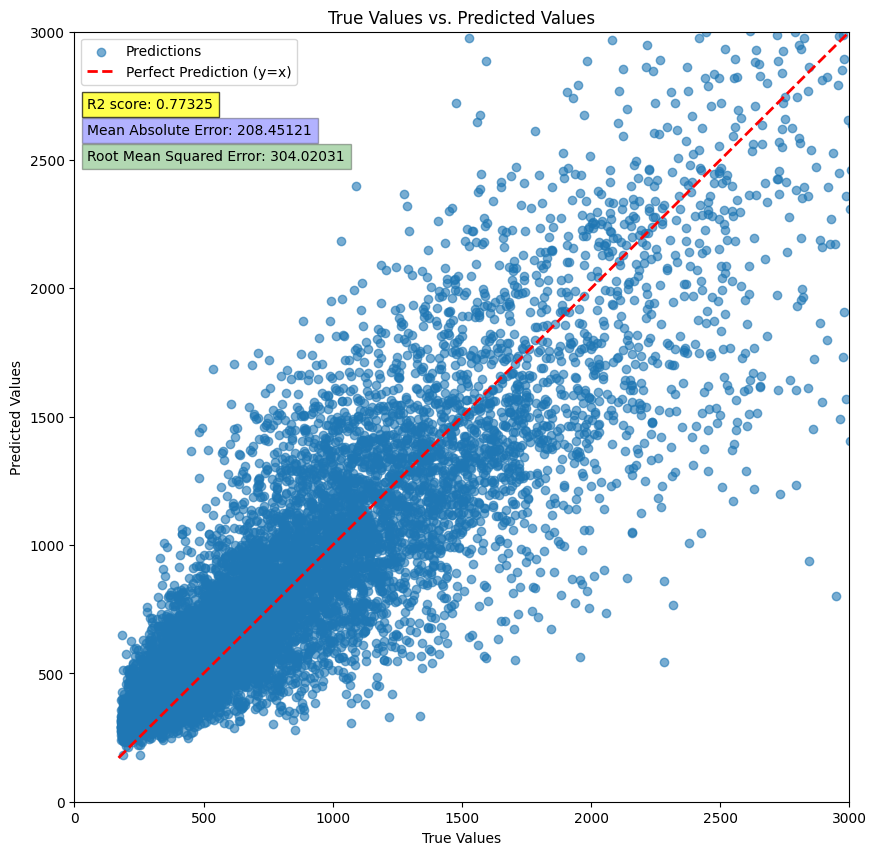

In [51]:
# plot the differences
plt.figure(figsize=(10,10))
plt.scatter(y_test_travel_time[:10000], best_preds_tt[:10000], alpha=0.6, label='Predictions')
# axis limits
plt.xlim([0,3000])
plt.ylim([0,3000])
#plotting perfect line
min_val = min(np.min(y_test_travel_time), np.min(best_preds_tt))
max_val = max(np.max(y_test_travel_time), np.max(best_preds_tt))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction (y=x)')
# other settings
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True Values vs. Predicted Values")
#plt.grid(True)
plt.legend()
plt.text(50,2700,f'R2 score: {r2_travel:.5f}',bbox=dict(facecolor='yellow', alpha=0.7))
plt.text(50,2600,f'Mean Absolute Error: {mae:.5f}',bbox=dict(facecolor='blue', alpha=0.3))
plt.text(50,2500,f'Root Mean Squared Error: {rmse:.5f}',bbox=dict(facecolor='green', alpha=0.3))
plt.show()